# <u>**Black-Scholes Option Pricing (Nifty50)**</u>

## 📌 Overview
This script calculates **theoretical option prices** for Nifty50 **Call** and **Put** options using the **Black-Scholes-Merton** model, compares them to market prices, and evaluates accuracy.

---

## ⚙️ Workflow
1. **Fetch Nifty50 historical volatility** using `yfinance`.
2. **Load NSE option chain CSV** and clean/format data.
3. **Apply Black-Scholes formula**:
   
   $$d_1 = \frac{\ln(S/K) + (r + 0.5\sigma^2)T}{\sigma\sqrt{T}}, \quad d_2 = d_1 - \sigma\sqrt{T}$$
   
4. **Compute errors** → MAE, MSE, RMSE.
5. **Plot** market vs model prices (Call = blue, Put = red).

---

## 📦 Dependencies
```bash
pip install numpy pandas scipy yfinance matplotlib


---

In [24]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

In [25]:
# --- 1. Black-Scholes-Merton Model Implementation ---

def black_scholes(S, K, T, r, sigma, option_type):
    """
    Calculate the theoretical option price using the Black-Scholes-Merton model.

    Parameters:
    S (float)     : Current underlying asset price
    K (float)     : Option strike price
    T (float)     : Time to expiration in years
    r (float)     : Risk-free interest rate (annualized)
    sigma (float) : Annualized volatility of the underlying asset
    option_type   : 'call' or 'put'

    Returns:
    float: Theoretical price of the option
    """

    # If time to expiry is zero or negative, return intrinsic value (no time value left)
    if T <= 0:
        return max(0, S - K) if option_type == 'call' else max(0, K - S)

    # Calculate d1 and d2 for the BSM formula
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # For a call option: price = S*N(d1) - K*e^(-rT)*N(d2)
    if option_type == 'call':
        price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))

    # For a put option: price = K*e^(-rT)*N(-d2) - S*N(-d1)
    elif option_type == 'put':
        price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))

    # Handle invalid option types
    else:
        raise ValueError("Invalid option type. Must be 'call' or 'put'.")

    return price


In [26]:
# --- 2. Volatility and Data Preparation ---

def get_historical_volatility(ticker, period="1y"):
    """
    Calculate the annualized historical volatility of a stock/index.

    Parameters:
    ticker (str) : Yahoo Finance ticker symbol (e.g., '^NSEI' for Nifty50)
    period (str) : Historical data period (default: '1y')

    Returns:
    float: Annualized historical volatility
    """

    # Download historical price data from Yahoo Finance for the given period
    data = yf.download(ticker, period=period, progress=False)

    # Calculate daily log returns: ln(P_t / P_(t-1))
    data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))

    # Calculate annualized volatility:
    # std_dev of daily returns * sqrt(252 trading days in a year)
    volatility = data['log_return'].std() * np.sqrt(252)

    return volatility

def prepare_data(file_path):
    # Read CSV while preserving original structure
    df = pd.read_csv(file_path, skiprows=0, header=0)
    
    # Clean column names
    df.columns = [col.strip() for col in df.columns]
    
    # Extract strike prices
    df["STRIKE"] = df["STRIKE"].apply(
        lambda x: float(str(x).replace(',', '')) if str(x).strip() not in ['-', ''] else np.nan
    )
    
    # Remove rows with invalid strike prices
    df = df.dropna(subset=['STRIKE'])
    
    # Create empty DataFrames for calls and puts
    calls = pd.DataFrame()
    puts = pd.DataFrame()
    
    # Manually map columns based on known structure
    # Calls data: columns 1-10
    calls['OI'] = df.iloc[:, 1]
    calls['CHNG_IN_OI'] = df.iloc[:, 2]
    calls['VOLUME'] = df.iloc[:, 3]
    calls['IV'] = df.iloc[:, 4]
    calls['LTP'] = df.iloc[:, 5]
    calls['CHNG'] = df.iloc[:, 6]
    calls['BID_QTY'] = df.iloc[:, 7]
    calls['BID'] = df.iloc[:, 8]
    calls['ASK'] = df.iloc[:, 9]
    calls['ASK_QTY'] = df.iloc[:, 10]
    calls['Strike Price'] = df['STRIKE']
    calls['Option Type'] = 'call'
    
    # Puts data: columns 12-21
    puts['BID_QTY'] = df.iloc[:, 12]
    puts['BID'] = df.iloc[:, 13]
    puts['ASK'] = df.iloc[:, 14]
    puts['ASK_QTY'] = df.iloc[:, 15]
    puts['CHNG'] = df.iloc[:, 16]
    puts['LTP'] = df.iloc[:, 17]
    puts['IV'] = df.iloc[:, 18]
    puts['VOLUME'] = df.iloc[:, 19]
    puts['CHNG_IN_OI'] = df.iloc[:, 20]
    puts['OI'] = df.iloc[:, 21]
    puts['Strike Price'] = df['STRIKE']
    puts['Option Type'] = 'put'
    
    # Combine calls and puts
    options_df = pd.concat([calls, puts], ignore_index=True)
    
    # Add date and expiry information
    options_df['Date'] = pd.to_datetime('today').normalize()
    
    # Parse expiry date from filename
    try:
        expiry_str = file_path.split('-')[-3:]
        expiry_date = ' '.join(expiry_str).replace('.csv', '')
        options_df['Expiry'] = pd.to_datetime(expiry_date, format='%d %b %Y')
    except:
        options_df['Expiry'] = pd.to_datetime('2025-08-14')  # Fallback date
    
    # Calculate time to expiration
    options_df['T'] = (options_df['Expiry'] - options_df['Date']).dt.days / 365.0
    
    # Convert all columns to appropriate types
    numeric_cols = ['OI', 'CHNG_IN_OI', 'VOLUME', 'IV', 'LTP', 'CHNG', 
                    'BID_QTY', 'BID', 'ASK', 'ASK_QTY', 'Strike Price']
    
    for col in numeric_cols:
        options_df[col] = (
            options_df[col]
            .astype(str)
            .str.replace(',', '')
            .replace(['-', ' ', 'nan', 'NaN', ''], '0')
            .astype(float)
        )
    
    # Filter valid options
    options_df = options_df[options_df['LTP'] > 0]
    
    return options_df

## **FOR FUTURE OPTIONS**
### Used 28-Oct-2025 Nifty50 Expiry Date

Fetching historical volatility for ^NSEI...


/var/folders/yh/r_y0_1096fx80kg5yrpqly5r0000gn/T/ipykernel_61793/2114738409.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, progress=False)


Annualized Historical Volatility: 13.14%

Using Underlying Price (S): 24631.30

Loading and preparing options data from option-chain-ED-NIFTY-28-Oct-2025.csv...
Total options loaded: 138


--- Model Accuracy Assessment ---
Mean Absolute Error (MAE): 63.9698
Mean Squared Error (MSE): 6609.1412
Root Mean Squared Error (RMSE): 81.2966
Note: Errors are in the same units as option prices (INR).

--- Sample Results (First 10 Rows) ---
    Strike Price Option Type      LTP     BS_Price      Error
4        22800.0        call  2105.55  2192.563255  87.013255
5        22850.0        call  2059.75  2146.496797  86.746797
6        22900.0        call  2014.25  2100.670519  86.420519
7        22950.0        call  1969.00  2055.097408  86.097408
8        23000.0        call  1960.00  2009.790750  49.790750
9        23050.0        call  1879.40  1964.764116  85.364116
10       23100.0        call  1834.75  1920.031333  85.281333
11       23150.0        call  1790.35  1875.606458  85.256458
12       

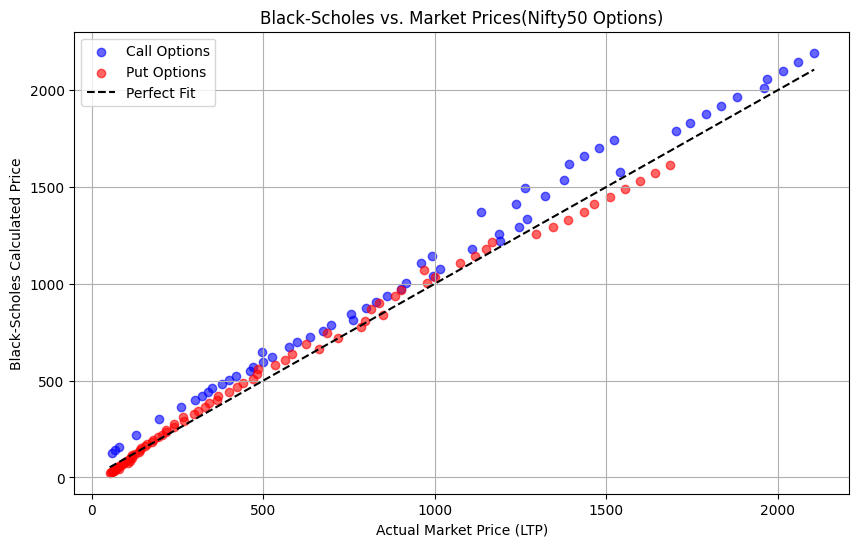

In [27]:
# --- 3. Main Analysis and Visualization ---

if __name__ == "__main__":
    NIFTY_TICKER = '^NSEI'
    RISK_FREE_RATE = 0.072
    OPTIONS_DATA_FILE = 'option-chain-ED-NIFTY-28-Oct-2025.csv'

    print(f"Fetching historical volatility for {NIFTY_TICKER}...")
    nifty_volatility = get_historical_volatility(NIFTY_TICKER)
    print(f"Annualized Historical Volatility: {nifty_volatility:.2%}\n")
    
    nifty_info = yf.Ticker(NIFTY_TICKER)
    nifty_history = nifty_info.history(period="5d")
    current_underlying_price = nifty_history['Close'].iloc[-1]
    print(f"Using Underlying Price (S): {current_underlying_price:.2f}\n")

    print(f"Loading and preparing options data from {OPTIONS_DATA_FILE}...")
    options_df = prepare_data(OPTIONS_DATA_FILE)
    print(f"Total options loaded: {len(options_df)}\n")

    # Calculate Black-Scholes prices
    bs_prices = []
    for _, row in options_df.iterrows():
        price = black_scholes(
            S=current_underlying_price,
            K=row['Strike Price'],
            T=row['T'],
            r=RISK_FREE_RATE,
            sigma=nifty_volatility,
            option_type=row['Option Type']
        )
        bs_prices.append(price)
    
    options_df['BS_Price'] = bs_prices
    options_df['Error'] = options_df['BS_Price'] - options_df['LTP']
    options_df['Absolute_Error'] = abs(options_df['Error'])
    options_df['Squared_Error'] = options_df['Error'] ** 2

    # Calculate accuracy metrics
    mae = options_df['Absolute_Error'].mean()
    mse = options_df['Squared_Error'].mean()
    rmse = np.sqrt(mse)

    print("\n--- Model Accuracy Assessment ---")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("Note: Errors are in the same units as option prices (INR).")

    calls = options_df[options_df['Option Type'] == 'call']
    puts = options_df[options_df['Option Type'] == 'put']

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(calls['LTP'], calls['BS_Price'], c='blue', alpha=0.6, label='Call Options')
    plt.scatter(puts['LTP'], puts['BS_Price'], c='red', alpha=0.6, label='Put Options')
    plt.plot([options_df['LTP'].min(), options_df['LTP'].max()],
             [options_df['LTP'].min(), options_df['LTP'].max()], 
             'k--', label='Perfect Fit')
    plt.title('Black-Scholes vs. Market Prices(Nifty50 Options)')
    plt.xlabel('Actual Market Price (LTP)')
    plt.ylabel('Black-Scholes Calculated Price')
    plt.legend()
    plt.grid(True)

    # Print results sample
    print("\n--- Sample Results (First 10 Rows) ---")
    print(options_df[['Strike Price', 'Option Type', 'LTP', 'BS_Price', 'Error']].head(10))

---

## **FOR PREVIOUSLY CLOSED OPTIONS**
### Used 14-Aug-2025 Nifty50 Expiry Date

In [28]:
# --- 2. Volatility and Data Preparation ---

def get_historical_volatility(ticker, period="1y"):
    """
    Calculate the annualized historical volatility of a stock/index.

    Parameters:
    ticker (str) : Yahoo Finance ticker symbol (e.g., '^NSEI' for Nifty50)
    period (str) : Historical data period (default: '1y')

    Returns:
    float: Annualized historical volatility
    """

    # Download historical price data from Yahoo Finance for the given period
    data = yf.download(ticker, period=period, progress=False)

    # Calculate daily log returns: ln(P_t / P_(t-1))
    data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))

    # Calculate annualized volatility:
    # std_dev of daily returns * sqrt(252 trading days in a year)
    volatility = data['log_return'].std() * np.sqrt(252)

    return volatility

def prepare_data(file_path):
    # Read CSV while preserving original structure
    df = pd.read_csv(file_path, skiprows=0, header=0)
    
    # Clean column names
    df.columns = [col.strip() for col in df.columns]
    
    # Extract strike prices
    df["STRIKE"] = df["STRIKE"].apply(
        lambda x: float(str(x).replace(',', '')) if str(x).strip() not in ['-', ''] else np.nan
    )
    
    # Remove rows with invalid strike prices
    df = df.dropna(subset=['STRIKE'])
    
    # Create empty DataFrames for calls and puts
    calls = pd.DataFrame()
    puts = pd.DataFrame()
    
    # Manually map columns based on known structure
    # Calls data: columns 1-10
    calls['OI'] = df.iloc[:, 1]
    calls['CHNG_IN_OI'] = df.iloc[:, 2]
    calls['VOLUME'] = df.iloc[:, 3]
    calls['IV'] = df.iloc[:, 4]
    calls['LTP'] = df.iloc[:, 5]
    calls['CHNG'] = df.iloc[:, 6]
    calls['BID_QTY'] = df.iloc[:, 7]
    calls['BID'] = df.iloc[:, 8]
    calls['ASK'] = df.iloc[:, 9]
    calls['ASK_QTY'] = df.iloc[:, 10]
    calls['Strike Price'] = df['STRIKE']
    calls['Option Type'] = 'call'
    
    # Puts data: columns 12-21
    puts['BID_QTY'] = df.iloc[:, 12]
    puts['BID'] = df.iloc[:, 13]
    puts['ASK'] = df.iloc[:, 14]
    puts['ASK_QTY'] = df.iloc[:, 15]
    puts['CHNG'] = df.iloc[:, 16]
    puts['LTP'] = df.iloc[:, 17]
    puts['IV'] = df.iloc[:, 18]
    puts['VOLUME'] = df.iloc[:, 19]
    puts['CHNG_IN_OI'] = df.iloc[:, 20]
    puts['OI'] = df.iloc[:, 21]
    puts['Strike Price'] = df['STRIKE']
    puts['Option Type'] = 'put'
    
    # Combine calls and puts
    options_df = pd.concat([calls, puts], ignore_index=True)
    
    # Add date and expiry information
    options_df['Date'] = pd.to_datetime('today').normalize()
    
    # Parse expiry date from filename
    try:
        expiry_str = file_path.split('-')[-3:]
        expiry_date = ' '.join(expiry_str).replace('.csv', '')
        options_df['Expiry'] = pd.to_datetime(expiry_date, format='%d %b %Y')
    except:
        options_df['Expiry'] = pd.to_datetime('2025-08-14')  # Fallback date
    
    # Calculate time to expiration
    options_df['T'] = (options_df['Expiry'] - options_df['Date']).dt.days / 365.0
    
    # Convert all columns to appropriate types
    numeric_cols = ['OI', 'CHNG_IN_OI', 'VOLUME', 'IV', 'LTP', 'CHNG', 
                    'BID_QTY', 'BID', 'ASK', 'ASK_QTY', 'Strike Price']
    
    for col in numeric_cols:
        options_df[col] = (
            options_df[col]
            .astype(str)
            .str.replace(',', '')
            .replace(['-', ' ', 'nan', 'NaN', ''], '0')
            .astype(float)
        )
    
    # Filter valid options
    options_df = options_df[options_df['LTP'] > 0]
    
    return options_df

Fetching historical volatility for ^NSEI...
Annualized Historical Volatility: 13.14%



/var/folders/yh/r_y0_1096fx80kg5yrpqly5r0000gn/T/ipykernel_61793/2114738409.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, progress=False)


Using Underlying Price (S): 24631.30

Loading and preparing options data from option-chain-ED-NIFTY-14-Aug-2025.csv...
Total options loaded: 178


--- Model Accuracy Assessment ---
Mean Absolute Error (MAE): 7.6728
Mean Squared Error (MSE): 672.6659
Root Mean Squared Error (RMSE): 25.9358
Note: Errors are in the same units as option prices (INR).

--- Sample Results (First 10 Rows) ---
    Strike Price Option Type      LTP     BS_Price       Error
4        22800.0        call  1832.40  1831.300781   -1.099219
5        22850.0        call  1700.00  1781.300781   81.300781
6        22900.0        call  1693.30  1731.300781   38.000781
7        22950.0        call  1684.25  1681.300781   -2.949219
8        23000.0        call  1631.85  1631.300781   -0.549219
9        23050.0        call  1580.00  1581.300781    1.300781
10       23100.0        call  1538.00  1531.300781   -6.699219
11       23150.0        call  1470.00  1481.300781   11.300781
12       23200.0        call  1418.40  1431.

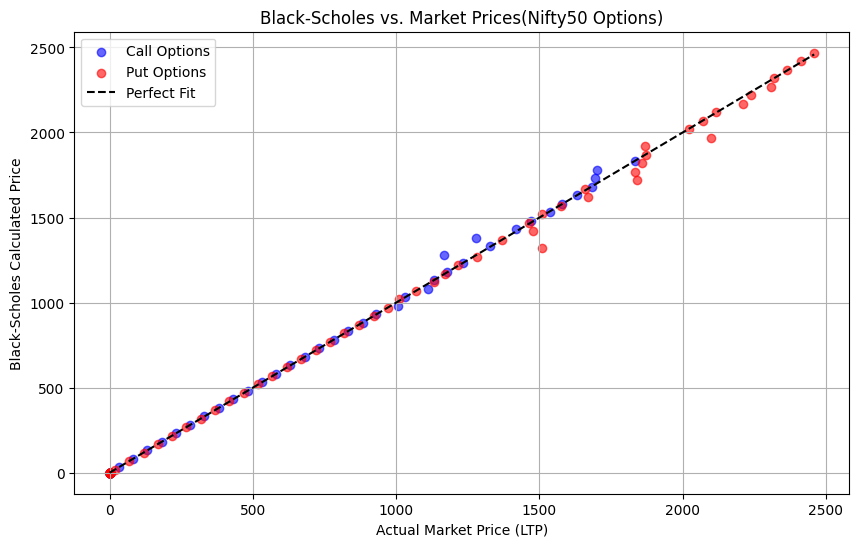

In [29]:

if __name__ == "__main__":
    NIFTY_TICKER = '^NSEI'
    RISK_FREE_RATE = 0.072
    OPTIONS_DATA_FILE = 'option-chain-ED-NIFTY-14-Aug-2025.csv'

    print(f"Fetching historical volatility for {NIFTY_TICKER}...")
    nifty_volatility = get_historical_volatility(NIFTY_TICKER)
    print(f"Annualized Historical Volatility: {nifty_volatility:.2%}\n")
    
    nifty_info = yf.Ticker(NIFTY_TICKER)
    nifty_history = nifty_info.history(period="5d")
    current_underlying_price = nifty_history['Close'].iloc[-1]
    print(f"Using Underlying Price (S): {current_underlying_price:.2f}\n")

    print(f"Loading and preparing options data from {OPTIONS_DATA_FILE}...")
    options_df = prepare_data(OPTIONS_DATA_FILE)
    print(f"Total options loaded: {len(options_df)}\n")
    
    # Calculate Black-Scholes prices
    bs_prices = []
    for _, row in options_df.iterrows():
        price = black_scholes(
            S=current_underlying_price,
            K=row['Strike Price'],
            T=row['T'],
            r=RISK_FREE_RATE,
            sigma=nifty_volatility,
            option_type=row['Option Type']
        )
        bs_prices.append(price)
    
    options_df['BS_Price'] = bs_prices
    options_df['Error'] = options_df['BS_Price'] - options_df['LTP']
    options_df['Absolute_Error'] = abs(options_df['Error'])
    options_df['Squared_Error'] = options_df['Error'] ** 2

    # Calculate accuracy metrics
    mae = options_df['Absolute_Error'].mean()
    mse = options_df['Squared_Error'].mean()
    rmse = np.sqrt(mse)

    print("\n--- Model Accuracy Assessment ---")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("Note: Errors are in the same units as option prices (INR).")

    calls = options_df[options_df['Option Type'] == 'call']
    puts = options_df[options_df['Option Type'] == 'put']

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(calls['LTP'], calls['BS_Price'], c='blue', alpha=0.6, label='Call Options')
    plt.scatter(puts['LTP'], puts['BS_Price'], c='red', alpha=0.6, label='Put Options')
    plt.plot([options_df['LTP'].min(), options_df['LTP'].max()],
             [options_df['LTP'].min(), options_df['LTP'].max()], 
             'k--', label='Perfect Fit')
    plt.title('Black-Scholes vs. Market Prices(Nifty50 Options)')
    plt.xlabel('Actual Market Price (LTP)')
    plt.ylabel('Black-Scholes Calculated Price')
    plt.legend()
    plt.grid(True)

    # Print results sample
    print("\n--- Sample Results (First 10 Rows) ---")
    print(options_df[['Strike Price', 'Option Type', 'LTP', 'BS_Price', 'Error']].head(10))